# PHASE 2 MOVIE MARKET ANALYSIS FOR NEW STUDIO LAUNCH
# AUTHOR: Leslie Nungi 
# LinkedIn:www.linkedin.com/in/leslie-nungi-17499627b
# objective:
- The company is entering the film industry.we are exploring various types of movies that perform well at the box office. This notebook analyzes datasets from IMDB and Box Oficce Mojo to find trends that can inform our strategy.
# Stakeholder:
- The head of our company.
# Goal:
- Make 3 data-driven recommendations on which type of movies to produce.

## Import libraries

In [47]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns 

### set style for charts

In [48]:
sns.set(style='whitegrid')
plt.rcParams['figure.figsize']=(10,6)

### Load the Data
First lets load the data and explore datasets.


In [49]:
conn= sqlite3.connect("im.db")
imdb_tables= pd.read_sql("""
                            SELECT name
                            FROM sqlite_master
                            WHERE type='table';
                            """,conn)
imdb_tables

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [50]:
basics_df= pd.read_sql("""
                       SELECT *
                       FROM movie_basics
                       """,conn)
ratings_df= pd.read_sql("""
                            SELECT *
                            FROM movie_ratings
                            """,conn)

conn.close()

## DATA CLEANING AND MERGING

In [51]:
#BASIC CLEANING
basics_df= basics_df[basics_df['runtime_minutes'].notnull()]
basics_df= basics_df[basics_df['genres'].notnull()]

#merge imdb data
imdb_df= pd.merge(basics_df,ratings_df, on='movie_id')

# convert runtime to numeric
imdb_df['runtime_minutes']= pd.to_numeric(imdb_df['runtime_minutes'],errors='coerce')

# remove very short or very long movies
imdb_df= imdb_df[(imdb_df['runtime_minutes']>30) & (imdb_df['runtime_minutes']<240)]

## LOADING AND CLEANING BOX OFFICE MOJO DATA

In [52]:
# Load the BOM data
bom_df = pd.read_csv("bom.movie_gross.csv.gz")

# Clean column names
bom_df.columns = bom_df.columns.str.strip().str.lower()

# Check structure
print(bom_df.columns)

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')


In [53]:
# Remove missing values
bom_df = bom_df.dropna(subset=['domestic_gross', 'foreign_gross'])

# Remove $ and , and convert to float
bom_df['domestic_gross'] = bom_df['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)
bom_df['foreign_gross'] = bom_df['foreign_gross'].replace('[\$,]', '', regex=True).astype(float)

# Create worldwide gross
bom_df['worldwide_gross'] = bom_df['domestic_gross'] + bom_df['foreign_gross']


## MERGE DATASETS

In [58]:
df_merged=pd.merge(bom_df, imdb_df, left_on='title', right_on='primary_title',how='inner')

# then we drop rows with missing values
df_merged=df_merged.dropna(subset=['genres','runtime_minutes','worldwide_gross'])

## DATA ANALYSIS
### 1. GENRE VS. AVERAGE WORLDWIDE GROSS

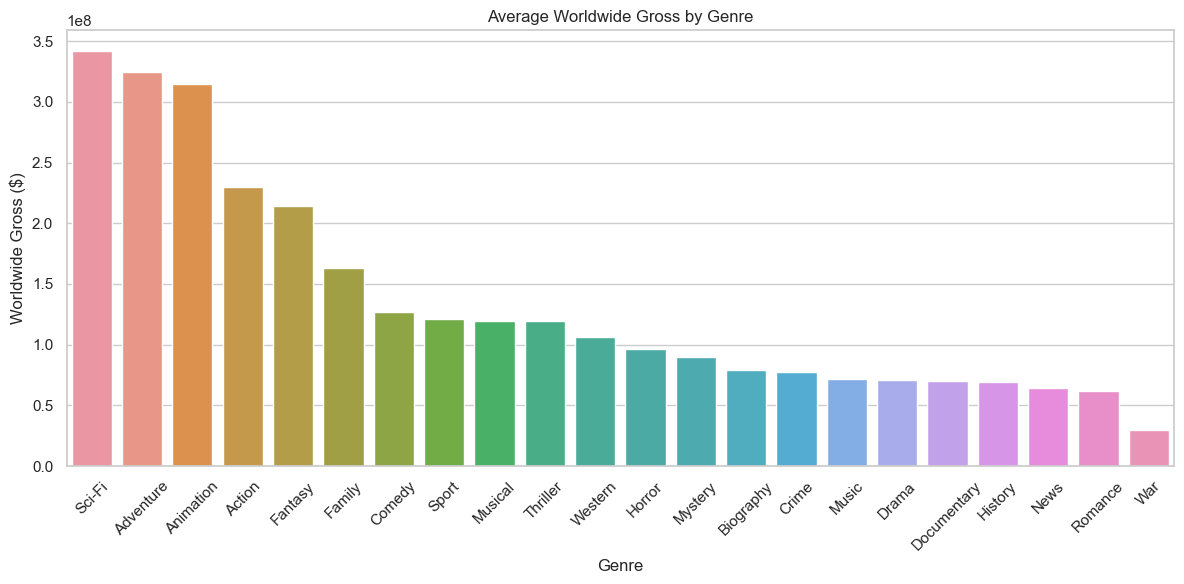

In [59]:
df_merged['genres_split'] = df_merged['genres'].str.split(',')
df_genres = df_merged.explode('genres_split')
genre_gross = df_genres.groupby('genres_split')['worldwide_gross'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_gross.index, y=genre_gross.values)
plt.title("Average Worldwide Gross by Genre")
plt.ylabel("Worldwide Gross ($)")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### RECOMMENDATION 1: 
- Invest in producing movies in top grossing genres like Sci-fi,Adventure, Animation and Action.

### 2.RUNTIME VS. AVERAGE WORLDWIDE GROSS

C:\Users\CATE\AppData\Local\Temp\ipykernel_13540\2786457294.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_gross = df_merged.groupby('runtime_bins')['worldwide_gross'].mean()
C:\Users\CATE\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


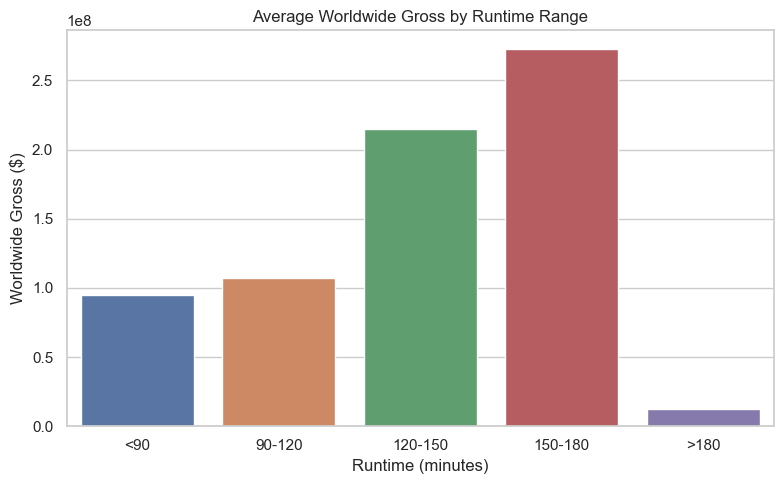

In [60]:
df_merged['runtime_bins'] = pd.cut(df_merged['runtime_minutes'], bins=[0, 90, 120, 150, 180, 300], labels=["<90", "90-120", "120-150", "150-180", ">180"])
runtime_gross = df_merged.groupby('runtime_bins')['worldwide_gross'].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=runtime_gross.index, y=runtime_gross.values)
plt.title("Average Worldwide Gross by Runtime Range")
plt.ylabel("Worldwide Gross ($)")
plt.xlabel("Runtime (minutes)")
plt.tight_layout()
plt.show()

#### RECOMMENDATION 2:
- Aim for runtimes between 120-150 or 150- 180 minutes which tend to perform best globallly

### 3. IMDB RATINGS VS. AVERAGE WORLDWIDE GROSS

C:\Users\CATE\AppData\Local\Temp\ipykernel_13540\893976042.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_avg_gross = df_merged.groupby('year_bins')['worldwide_gross'].mean()


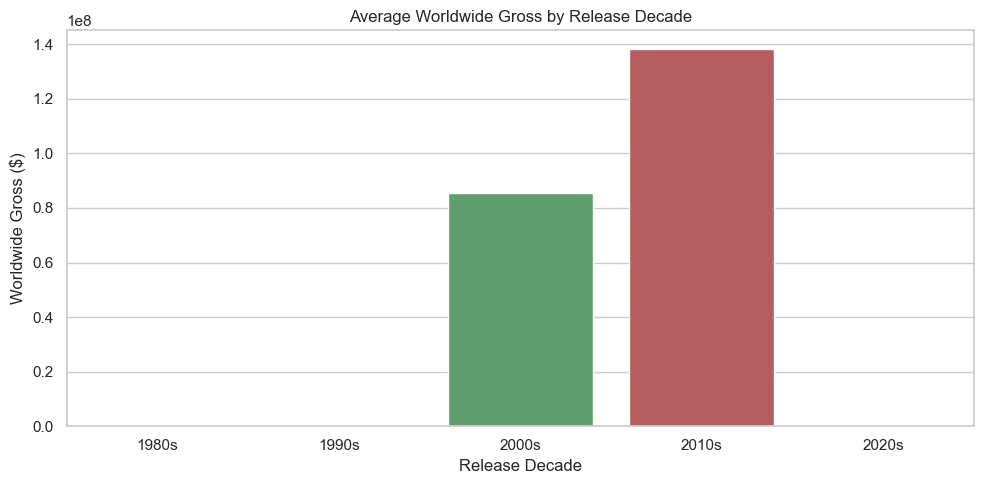

In [67]:
year_bins = pd.cut(df_merged['start_year'], bins=[1980, 1990, 2000, 2010, 2020, 2030], labels=["1980s", "1990s", "2000s", "2010s", "2020s"])
df_merged['year_bins'] = year_bins
year_avg_gross = df_merged.groupby('year_bins')['worldwide_gross'].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=year_avg_gross.index.astype(str), y=year_avg_gross.values)
plt.title("Average Worldwide Gross by Release Decade")
plt.xlabel("Release Decade")
plt.ylabel("Worldwide Gross ($)")
plt.tight_layout()
plt.show()

### RECOMMENDATION 3:
- Focus on movies released in the  2000s and 2010s as they show the highest revenue trends.

# CONCLUSION
- Our analysis of movie genre, runtime and release year show that the most successful movies are:
> - In genres like Sci-fi, Adventure, Animation and Action.
> - Between 120-150 and 150-180 minute long.
> - released in the 2000s and 2010s (suggesting that newer films are doing better.)

This insights can guide the new studio's strategy and resource allocation for maximum profitability.